## **Importing model from Hugging face**

In [ ]:
! pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
%%capture
! pip install git+https://github.com/huggingface/huggingface_hub.git@main
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
from huggingface_hub import push_to_hub_keras
from huggingface_hub import from_pretrained_keras

In [ ]:
# custom model trained on small dataset https://keras.io/examples/vision/vit_small_ds/

loaded_model = from_pretrained_keras("keras-io/vit-small-ds")

config.json not found in HuggingFace Hub.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 shifted_patch_tokenization (Sh  ((None, 144, 64),   35704       ['input_layer[0][0]']            
 iftedPatchTokenization)         (None, 12, 12, 540                                               
                                ))                                                                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      9216        ['shifted_patch_tokenization[0][0
                                                                 ]']                          

## **Customize model to fine tune it**

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
def gen_models(modelInput):
  input = modelInput.layers[-3].output
  fc1 = layers.Dense(4096, activation='relu', name = 'fc1')(input)
  fc2 = layers.Dense(2048, activation='relu', name = 'fc2')(fc1)
  fc3 = layers.Dense(1024, activation='relu', name = 'fc3')(fc2)
  fc4 = layers.Dense(512, activation='relu', name = 'fc4')(fc3)
  softmax = layers.Dense(10, activation='softmax', name = 'softmax')(fc4)
  model = Model(inputs=modelInput.inputs, outputs=softmax)
  return model

In [ ]:
model = gen_models(loaded_model)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 shifted_patch_tokenization (Sh  ((None, 144, 64),   35704       ['input_layer[0][0]']            
 iftedPatchTokenization)         (None, 12, 12, 540                                               
                                ))                                                                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      9216        ['shifted_patch_tokenization[0][0
                                                                 ]']                        

## **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## **Importing libraries**

In [ ]:
%%capture

!pip install codecarbon
!pip install vit-keras
!pip install mxnet
!pip install tensorflow-addons==0.16.1

In [ ]:
import os
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow_addons as tfa

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker
import itertools

from tensorflow.keras.utils import load_img
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence as Sequence
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical
import mxnet as mx
from vit_keras import vit, utils
from enum import Enum

In [ ]:
## File images path
base_path = "MY_PATH"
base_path_img = "MY_PATH"

## Data Generator values
inp_dim = (72,72)
n_channels = 3
n_classes = 10

## Image files list
imgs_list = os.listdir(base_path_img)

## Image size
input_size = (72, 72, 3)

## Training, Validation and Testing Percent
train_perc = 0.8

## Epoch numbers for fine tuning
num_epochs = 30
num_epochs_grid = 10

## plotlib results number
num_results = 20


## **Prepare data**

In [ ]:
## Define different classes to create each label

img_ids = ["ic_CIE.front.", "ic_CIE.rear.", "dl_I11.front.", "dl_I11.rear.", "dl_I10.front.", "dl_I10.rear.", "ic_TES.front.", "ic_TES.rear.", "doc_NR.front.", "doc_NR.rear."]

def switch(img_id):
    for i, id in enumerate(img_ids):
        if id in img_id:
            return i
    return None

In [ ]:
#Augment data randomly throw rotation, brightless and lighting

def switch_aug(img_):
  temp_img = img_.copy()
  rndm_value = random.uniform(0.2, 0.6)
  rndm_type = random.randint(0, 2)
  if rndm_type == 0:
    alpha = np.random.normal(0, 100, size=(3,))
    rgb = np.dot(np.asarray([1,1,1]) * alpha, np.ones((3,3)))
    img_ = temp_img + rgb
  elif rndm_type == 1:
    aug = mx.image.BrightnessJitterAug(brightness=rndm_value)
    img_ = aug(temp_img)
  elif rndm_type == 2:
    img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

def augment_data(img_):
  img_ = switch_aug(img_)
  img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

In [ ]:
# Data generator

def data_generation(list_IDs_temp, train, size):
        ## Initialization with empty tensors
        X = np.empty((size, *inp_dim, n_channels))
        y = np.empty((size), dtype=int)

        # Generate data: for i in batch_size fill the input and label vectors
        for i, (ID, augmented) in enumerate(list_IDs_temp):
          ## Get image
          img = load_img(ID, target_size = inp_dim)
          img = img_to_array(img)
          img = img / 255.0

          current_index_class = switch(ID)
          if train:
            if augmented:
                img = augment_data(img)

          ## Store images
          X[i, ] = img

          ## Store classes
          y[i] = current_index_class

        return X, y

In [ ]:
## shuffle datas
random.shuffle(imgs_list)
imgs_list = [os.path.join(base_path_img, img) for img in imgs_list]

## create empty tuple list
imgs_list_aug = []

## create dict with img_class index and all images of that class
balanced_img = {switch(i): [] for i in img_ids}
for j in imgs_list:
  h = switch(j)
  balanced_img[h].append((j, False))

#find the largest class
max_len = max([len(i) for i in balanced_img.values()])

## recreate balanced_img with same dimension
for img_class, img_list_data in balanced_img.items():
  for h in range((max_len + 1) - len(img_list_data)):
    my_list = random.sample(img_list_data,1)
    balanced_img[img_class].append((my_list[0][0], True))

## reduce balanced_img to list
for i in balanced_img.values():
  for j in i:
    imgs_list_aug.append(j)

random.shuffle(imgs_list_aug)

In [ ]:
#Define train and test sets

train_gen_number = int((len(imgs_list_aug) * train_perc))
train_data = imgs_list_aug[:train_gen_number]

test_gen_number = int(len(imgs_list_aug))
test_data = imgs_list_aug[len(train_data):test_gen_number]


X_train, y_train = data_generation(train_data, train=True, size = train_gen_number)
X_test, y_test = data_generation(test_data, train=False, size = len(test_data))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(768, 72, 72, 3) (768,) (192, 72, 72, 3) (192,)


[[[0.79215688 0.7764706  0.7647059 ]
  [0.78039217 0.7764706  0.76862746]
  [0.78823531 0.78431374 0.7764706 ]
  ...
  [0.72941178 0.72941178 0.72156864]
  [0.73333335 0.73333335 0.72549021]
  [0.72156864 0.72156864 0.71372551]]

 [[0.78823531 0.77254903 0.76078433]
  [0.78039217 0.7764706  0.76862746]
  [0.79607844 0.79215688 0.78431374]
  ...
  [0.71764708 0.71764708 0.70980394]
  [0.72941178 0.72941178 0.72156864]
  [0.73333335 0.73333335 0.72549021]]

 [[0.78431374 0.7647059  0.75294119]
  [0.78823531 0.77254903 0.76862746]
  [0.78823531 0.78431374 0.7764706 ]
  ...
  [0.74117649 0.74117649 0.73333335]
  [0.72941178 0.72941178 0.72156864]
  [0.71372551 0.71764708 0.69803923]]

 ...

 [[0.73333335 0.71764708 0.71372551]
  [0.72549021 0.70980394 0.70588237]
  [0.72941178 0.71372551 0.70980394]
  ...
  [0.73333335 0.73333335 0.73333335]
  [0.72156864 0.72156864 0.71372551]
  [0.70980394 0.70980394 0.7019608 ]]

 [[0.70980394 0.70588237 0.69803923]
  [0.73333335 0.71764708 0.71372551]


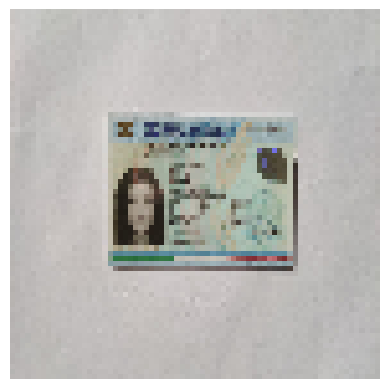

In [ ]:
image_index = np.random.choice(range(X_train.shape[0]))
image = X_train[image_index]
image_label = y_train[image_index]
print(image)

plt.imshow(image)
plt.axis('off')
plt.show()

## **Define grid search**

In [ ]:
# Define parameters and create grid search

learning_rates = [0.001, 0.0001]
weight_decays = [0.001, 0.0001]

my_optimizers = []

for learning_rate in learning_rates:
  for weight_decay in weight_decays:
    my_optimizers.append(tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay))

In [ ]:
print(len(my_optimizers))

4


In [ ]:
# Util function

def reduce_list(lst):
    temp = []
    for i, item in enumerate(lst):
        if isinstance(item, (list, tuple)):
            temp.append([item[-1], i])
        else:
            temp.append([item, i])
    return temp

In [ ]:
# Define best values hyperparameters

best_accuracies = []
best_val_accuracies = []
less_emissions = []
less_losses = []
less_val_losses = []

for my_optimizer in my_optimizers:
  model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ],
        optimizer = my_optimizer
    )
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
  tracker = EmissionsTracker()
  tracker.start()
  history = model.fit(x=X_train, y=y_train, epochs=num_epochs_grid,validation_split=0.15, verbose = 1,callbacks=[es])
  emissions: float = tracker.stop()
  best_accuracies.append(history.history["accuracy"])
  best_val_accuracies.append(history.history["val_accuracy"])
  less_emissions.append(emissions)
  less_losses.append(history.history["loss"])
  less_val_losses.append(history.history["val_loss"])

print(best_accuracies)
print(best_val_accuracies)
print(less_emissions)
print(less_losses)
print(less_val_losses)

[codecarbon INFO @ 09:44:33] [setup] RAM Tracking...
[codecarbon INFO @ 09:44:33] [setup] GPU Tracking...
[codecarbon INFO @ 09:44:33] No GPU found.
[codecarbon INFO @ 09:44:33] [setup] CPU Tracking...
[codecarbon WARNING @ 09:44:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:44:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:44:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:44:35] >>> Tracker's metadata:
[codecarbon INFO @ 09:44:35]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 09:44:35]   Python version: 3.10.12
[codecarbon INFO @ 09:44:35]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 09:44:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 09:44:35]   CPU count: 2
[codecarbon INFO @ 09:44:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:44:35]   GPU count: None
[cod

Epoch 1/10


[codecarbon INFO @ 09:44:50] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:44:50] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:44:50] 0.000197 kWh of electricity used since the beginning.


 4/21 [====>.........................] - ETA: 43s - loss: 2.5469 - accuracy: 0.1328

[codecarbon INFO @ 09:45:05] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:45:05] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:05] 0.000394 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 28s - loss: 2.3143 - accuracy: 0.1437

[codecarbon INFO @ 09:45:20] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:45:20] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:20] 0.000591 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 16s - loss: 2.2358 - accuracy: 0.1729

[codecarbon INFO @ 09:45:35] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:45:35] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:35] 0.000788 kWh of electricity used since the beginning.


21/21 [==============================] - ETA: 0s - loss: 2.1377 - accuracy: 0.2025

[codecarbon INFO @ 09:45:50] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:45:50] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:50] 0.000984 kWh of electricity used since the beginning.


21/21 [==============================] - 77s 3s/step - loss: 2.1377 - accuracy: 0.2025 - val_loss: 1.6991 - val_accuracy: 0.3793
Epoch 2/10
 4/21 [====>.........................] - ETA: 43s - loss: 1.8315 - accuracy: 0.2812

[codecarbon INFO @ 09:46:05] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:46:05] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:05] 0.001181 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 28s - loss: 1.6858 - accuracy: 0.3281

[codecarbon INFO @ 09:46:20] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:46:20] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:20] 0.001378 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 15s - loss: 1.6176 - accuracy: 0.3479

[codecarbon INFO @ 09:46:35] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:46:35] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:35] 0.001575 kWh of electricity used since the beginning.


21/21 [==============================] - 58s 3s/step - loss: 1.5321 - accuracy: 0.3819 - val_loss: 1.5519 - val_accuracy: 0.4052
Epoch 3/10


[codecarbon INFO @ 09:46:50] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:46:50] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:50] 0.001772 kWh of electricity used since the beginning.


 5/21 [======>.......................] - ETA: 44s - loss: 1.4542 - accuracy: 0.4313

[codecarbon INFO @ 09:47:05] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:47:05] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:05] 0.001969 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 27s - loss: 1.4411 - accuracy: 0.4318

[codecarbon INFO @ 09:47:20] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:47:20] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:20] 0.002166 kWh of electricity used since the beginning.


17/21 [=======================>......] - ETA: 10s - loss: 1.4074 - accuracy: 0.4596

[codecarbon INFO @ 09:47:35] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:47:35] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:35] 0.002363 kWh of electricity used since the beginning.


21/21 [==============================] - 58s 3s/step - loss: 1.3393 - accuracy: 0.4724 - val_loss: 1.2800 - val_accuracy: 0.4828
Epoch 4/10
 1/21 [>.............................] - ETA: 45s - loss: 1.0298 - accuracy: 0.5625

[codecarbon INFO @ 09:47:50] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:47:50] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:50] 0.002559 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 40s - loss: 1.0602 - accuracy: 0.5521

[codecarbon INFO @ 09:48:05] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:48:05] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:05] 0.002756 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 30s - loss: 1.1375 - accuracy: 0.5256

[codecarbon INFO @ 09:48:20] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:48:20] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:20] 0.002953 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 14s - loss: 1.1547 - accuracy: 0.5293

[codecarbon INFO @ 09:48:35] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:48:35] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:35] 0.003150 kWh of electricity used since the beginning.


21/21 [==============================] - 61s 3s/step - loss: 1.1226 - accuracy: 0.5460 - val_loss: 1.3211 - val_accuracy: 0.5086
Epoch 5/10


[codecarbon INFO @ 09:48:50] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:48:50] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:50] 0.003347 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 40s - loss: 0.9169 - accuracy: 0.6094

[codecarbon INFO @ 09:49:05] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:49:05] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:05] 0.003544 kWh of electricity used since the beginning.


12/21 [================>.............] - ETA: 23s - loss: 0.9205 - accuracy: 0.6016

[codecarbon INFO @ 09:49:20] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:49:20] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:20] 0.003740 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.8869 - accuracy: 0.6458 

[codecarbon INFO @ 09:49:35] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:49:35] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:35] 0.003937 kWh of electricity used since the beginning.


21/21 [==============================] - 58s 3s/step - loss: 0.8617 - accuracy: 0.6595 - val_loss: 1.0646 - val_accuracy: 0.6897
Epoch 6/10
 2/21 [=>............................] - ETA: 41s - loss: 0.6887 - accuracy: 0.7188

[codecarbon INFO @ 09:49:50] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:49:50] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:50] 0.004134 kWh of electricity used since the beginning.


 7/21 [=========>....................] - ETA: 36s - loss: 0.6305 - accuracy: 0.7679

[codecarbon INFO @ 09:50:05] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:50:05] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:05] 0.004331 kWh of electricity used since the beginning.


13/21 [=================>............] - ETA: 21s - loss: 0.7221 - accuracy: 0.7428

[codecarbon INFO @ 09:50:20] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:50:20] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:20] 0.004528 kWh of electricity used since the beginning.


19/21 [==========================>...] - ETA: 5s - loss: 0.7279 - accuracy: 0.7533

[codecarbon INFO @ 09:50:35] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:50:35] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:35] 0.004725 kWh of electricity used since the beginning.


21/21 [==============================] - 55s 3s/step - loss: 0.7224 - accuracy: 0.7469 - val_loss: 1.1655 - val_accuracy: 0.6638
Epoch 7/10
 3/21 [===>..........................] - ETA: 45s - loss: 0.4662 - accuracy: 0.8438

[codecarbon INFO @ 09:50:50] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:50:50] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:50] 0.004922 kWh of electricity used since the beginning.


 9/21 [===========>..................] - ETA: 30s - loss: 0.5902 - accuracy: 0.7882

[codecarbon INFO @ 09:51:05] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:51:05] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:05] 0.005119 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 15s - loss: 0.6183 - accuracy: 0.7750

[codecarbon INFO @ 09:51:20] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:51:20] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:20] 0.005316 kWh of electricity used since the beginning.


21/21 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.7914

[codecarbon INFO @ 09:51:35] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:51:35] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:35] 0.005513 kWh of electricity used since the beginning.


21/21 [==============================] - 56s 3s/step - loss: 0.6061 - accuracy: 0.7914 - val_loss: 1.1361 - val_accuracy: 0.6034
Epoch 8/10
 5/21 [======>.......................] - ETA: 43s - loss: 0.8162 - accuracy: 0.7563

[codecarbon INFO @ 09:51:50] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:51:50] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:50] 0.005710 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 29s - loss: 0.7275 - accuracy: 0.7750

[codecarbon INFO @ 09:52:05] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:52:05] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:05] 0.005907 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 13s - loss: 0.6127 - accuracy: 0.8145

[codecarbon INFO @ 09:52:20] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:52:20] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:20] 0.006103 kWh of electricity used since the beginning.


21/21 [==============================] - 58s 3s/step - loss: 0.5554 - accuracy: 0.8298 - val_loss: 0.7507 - val_accuracy: 0.7845
Epoch 9/10


[codecarbon INFO @ 09:52:35] Energy consumed for RAM : 0.000634 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:52:35] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:35] 0.006300 kWh of electricity used since the beginning.


 5/21 [======>.......................] - ETA: 43s - loss: 0.1839 - accuracy: 0.9187

[codecarbon INFO @ 09:52:50] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:52:50] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:50] 0.006497 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 26s - loss: 0.2453 - accuracy: 0.9205

[codecarbon INFO @ 09:53:05] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:53:05] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:05] 0.006694 kWh of electricity used since the beginning.


17/21 [=======================>......] - ETA: 10s - loss: 0.3799 - accuracy: 0.9026

[codecarbon INFO @ 09:53:20] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:53:20] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:20] 0.006891 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.3879 - accuracy: 0.8926 - val_loss: 0.8090 - val_accuracy: 0.7069
Epoch 10/10
 1/21 [>.............................] - ETA: 44s - loss: 0.2750 - accuracy: 0.8438

[codecarbon INFO @ 09:53:35] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:53:35] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:35] 0.007088 kWh of electricity used since the beginning.


 7/21 [=========>....................] - ETA: 36s - loss: 0.3096 - accuracy: 0.8839

[codecarbon INFO @ 09:53:50] Energy consumed for RAM : 0.000733 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:53:50] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:50] 0.007285 kWh of electricity used since the beginning.


13/21 [=================>............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8918

[codecarbon INFO @ 09:54:05] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:54:05] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:05] 0.007482 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.3205 - accuracy: 0.8993 

[codecarbon INFO @ 09:54:20] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:54:20] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:20] 0.007678 kWh of electricity used since the beginning.


21/21 [==============================] - 55s 3s/step - loss: 0.3195 - accuracy: 0.9003 - val_loss: 0.8580 - val_accuracy: 0.8190


[codecarbon INFO @ 09:54:26] Energy consumed for RAM : 0.000781 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:54:26] Energy consumed for all CPUs : 0.006981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:26] 0.007762 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:26] [setup] RAM Tracking...
[codecarbon INFO @ 09:54:26] [setup] GPU Tracking...
[codecarbon INFO @ 09:54:27] No GPU found.
[codecarbon INFO @ 09:54:27] [setup] CPU Tracking...
[codecarbon WARNING @ 09:54:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:54:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:54:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:54:28] >>> Tracker's metadata:
[codecarbon INFO @ 09:54:28]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 09:54:28]   Python version: 3.10.12

Epoch 1/10


[codecarbon INFO @ 09:54:44] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:54:44] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:44] 0.000197 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 35s - loss: 0.5097 - accuracy: 0.9219

[codecarbon INFO @ 09:54:59] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:54:59] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:59] 0.000394 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 24s - loss: 0.4424 - accuracy: 0.9091

[codecarbon INFO @ 09:55:14] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:55:14] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:14] 0.000591 kWh of electricity used since the beginning.


17/21 [=======================>......] - ETA: 9s - loss: 0.3979 - accuracy: 0.9026 

[codecarbon INFO @ 09:55:29] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:55:29] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:29] 0.000788 kWh of electricity used since the beginning.


21/21 [==============================] - 71s 3s/step - loss: 0.3996 - accuracy: 0.9049 - val_loss: 1.0665 - val_accuracy: 0.7845
Epoch 2/10
 1/21 [>.............................] - ETA: 49s - loss: 0.6202 - accuracy: 0.8750

[codecarbon INFO @ 09:55:44] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:55:44] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:44] 0.000985 kWh of electricity used since the beginning.


 7/21 [=========>....................] - ETA: 36s - loss: 0.4201 - accuracy: 0.9062

[codecarbon INFO @ 09:55:59] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:55:59] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:59] 0.001182 kWh of electricity used since the beginning.


12/21 [================>.............] - ETA: 23s - loss: 0.3549 - accuracy: 0.9193

[codecarbon INFO @ 09:56:14] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:56:14] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:14] 0.001378 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.3192 - accuracy: 0.9236 

[codecarbon INFO @ 09:56:29] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:56:29] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:29] 0.001575 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.3195 - accuracy: 0.9233 - val_loss: 0.7377 - val_accuracy: 0.7759
Epoch 3/10
 2/21 [=>............................] - ETA: 42s - loss: 0.2822 - accuracy: 0.9219

[codecarbon INFO @ 09:56:44] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:56:44] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:44] 0.001772 kWh of electricity used since the beginning.


 8/21 [==========>...................] - ETA: 33s - loss: 0.1308 - accuracy: 0.9648

[codecarbon INFO @ 09:56:59] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:56:59] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:59] 0.001969 kWh of electricity used since the beginning.


14/21 [===================>..........] - ETA: 17s - loss: 0.1204 - accuracy: 0.9710

[codecarbon INFO @ 09:57:14] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:57:14] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:14] 0.002166 kWh of electricity used since the beginning.


20/21 [===========================>..] - ETA: 2s - loss: 0.1385 - accuracy: 0.9719

[codecarbon INFO @ 09:57:29] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:57:29] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:29] 0.002363 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.1458 - accuracy: 0.9709 - val_loss: 1.9955 - val_accuracy: 0.8017
Epoch 4/10
 4/21 [====>.........................] - ETA: 38s - loss: 0.7044 - accuracy: 0.9141

[codecarbon INFO @ 09:57:44] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:57:44] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:44] 0.002560 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 27s - loss: 0.5682 - accuracy: 0.8844

[codecarbon INFO @ 09:57:59] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:57:59] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:59] 0.002757 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 15s - loss: 0.4448 - accuracy: 0.9021

[codecarbon INFO @ 09:58:14] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:58:14] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:14] 0.002954 kWh of electricity used since the beginning.


20/21 [===========================>..] - ETA: 2s - loss: 0.3763 - accuracy: 0.9156

[codecarbon INFO @ 09:58:29] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:58:29] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:29] 0.003150 kWh of electricity used since the beginning.


21/21 [==============================] - 60s 3s/step - loss: 0.3694 - accuracy: 0.9172 - val_loss: 0.7190 - val_accuracy: 0.7931
Epoch 5/10
 4/21 [====>.........................] - ETA: 38s - loss: 0.0614 - accuracy: 0.9766

[codecarbon INFO @ 09:58:44] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:58:44] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:44] 0.003347 kWh of electricity used since the beginning.


 9/21 [===========>..................] - ETA: 30s - loss: 0.2773 - accuracy: 0.9583

[codecarbon INFO @ 09:58:59] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:58:59] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:59] 0.003544 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 15s - loss: 0.3062 - accuracy: 0.9417

[codecarbon INFO @ 09:59:14] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:59:14] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:14] 0.003741 kWh of electricity used since the beginning.


21/21 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.9402

[codecarbon INFO @ 09:59:29] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:59:29] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:29] 0.003938 kWh of electricity used since the beginning.


21/21 [==============================] - 56s 3s/step - loss: 0.3476 - accuracy: 0.9402 - val_loss: 1.3133 - val_accuracy: 0.7500
Epoch 6/10
 5/21 [======>.......................] - ETA: 42s - loss: 0.2274 - accuracy: 0.9438

[codecarbon INFO @ 09:59:44] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:59:44] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:44] 0.004135 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 26s - loss: 0.2655 - accuracy: 0.9290

[codecarbon INFO @ 09:59:59] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 09:59:59] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:59] 0.004332 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 13s - loss: 0.2728 - accuracy: 0.9316

[codecarbon INFO @ 10:00:14] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:00:14] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:14] 0.004528 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.2723 - accuracy: 0.9279 - val_loss: 1.2469 - val_accuracy: 0.7500
Epoch 7/10
 1/21 [>.............................] - ETA: 45s - loss: 0.1409 - accuracy: 0.9688

[codecarbon INFO @ 10:00:29] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:00:29] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:29] 0.004725 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 40s - loss: 0.3433 - accuracy: 0.9375

[codecarbon INFO @ 10:00:44] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:00:44] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:44] 0.004923 kWh of electricity used since the beginning.


12/21 [================>.............] - ETA: 23s - loss: 0.2124 - accuracy: 0.9583

[codecarbon INFO @ 10:00:59] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:00:59] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:59] 0.005119 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.2029 - accuracy: 0.9618 

[codecarbon INFO @ 10:01:14] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:01:14] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:14] 0.005316 kWh of electricity used since the beginning.


21/21 [==============================] - 59s 3s/step - loss: 0.1831 - accuracy: 0.9663 - val_loss: 1.0908 - val_accuracy: 0.8190
Epoch 7: early stopping


[codecarbon INFO @ 10:01:26] Energy consumed for RAM : 0.000550 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:01:26] Energy consumed for all CPUs : 0.004921 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:26] 0.005471 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:26] [setup] RAM Tracking...
[codecarbon INFO @ 10:01:26] [setup] GPU Tracking...
[codecarbon INFO @ 10:01:26] No GPU found.
[codecarbon INFO @ 10:01:26] [setup] CPU Tracking...
[codecarbon WARNING @ 10:01:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:01:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:01:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:01:27] >>> Tracker's metadata:
[codecarbon INFO @ 10:01:27]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 10:01:27]   Python version: 3.10.12

Epoch 1/10


[codecarbon INFO @ 10:01:42] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:01:42] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:42] 0.000197 kWh of electricity used since the beginning.


 5/21 [======>.......................] - ETA: 44s - loss: 0.2668 - accuracy: 0.9750

[codecarbon INFO @ 10:01:57] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:01:57] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:57] 0.000394 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 26s - loss: 0.1415 - accuracy: 0.9858

[codecarbon INFO @ 10:02:12] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:02:12] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:12] 0.000591 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 13s - loss: 0.0983 - accuracy: 0.9902

[codecarbon INFO @ 10:02:27] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:02:27] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:27] 0.000788 kWh of electricity used since the beginning.


21/21 [==============================] - 74s 3s/step - loss: 0.0817 - accuracy: 0.9908 - val_loss: 0.9112 - val_accuracy: 0.8362
Epoch 2/10


[codecarbon INFO @ 10:02:42] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:02:42] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:42] 0.000984 kWh of electricity used since the beginning.


 5/21 [======>.......................] - ETA: 44s - loss: 0.0212 - accuracy: 0.9875

[codecarbon INFO @ 10:02:57] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W


 6/21 [=======>......................] - ETA: 40s - loss: 0.0178 - accuracy: 0.9896

[codecarbon INFO @ 10:02:57] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:57] 0.001181 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 26s - loss: 0.0161 - accuracy: 0.9915

[codecarbon INFO @ 10:03:12] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:03:13] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:13] 0.001378 kWh of electricity used since the beginning.


17/21 [=======================>......] - ETA: 10s - loss: 0.0308 - accuracy: 0.9908

[codecarbon INFO @ 10:03:27] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:03:28] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:28] 0.001575 kWh of electricity used since the beginning.


21/21 [==============================] - 58s 3s/step - loss: 0.0279 - accuracy: 0.9908 - val_loss: 0.8537 - val_accuracy: 0.8448
Epoch 3/10


[codecarbon INFO @ 10:03:43] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:03:43] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:43] 0.001771 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 39s - loss: 0.0040 - accuracy: 1.0000

[codecarbon INFO @ 10:03:58] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:03:58] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:58] 0.001968 kWh of electricity used since the beginning.


12/21 [================>.............] - ETA: 23s - loss: 0.0076 - accuracy: 0.9974

[codecarbon INFO @ 10:04:13] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:04:13] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:13] 0.002165 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.0106 - accuracy: 0.9965 

[codecarbon INFO @ 10:04:28] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:04:28] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:28] 0.002362 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.8019 - val_accuracy: 0.8448
Epoch 4/10
 2/21 [=>............................] - ETA: 41s - loss: 0.0044 - accuracy: 1.0000    

[codecarbon INFO @ 10:04:43] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:04:43] Energy consumed for all CPUs : 0.002301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:43] 0.002559 kWh of electricity used since the beginning.


 8/21 [==========>...................] - ETA: 32s - loss: 0.0043 - accuracy: 1.0000

[codecarbon INFO @ 10:04:58] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:04:58] Energy consumed for all CPUs : 0.002478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:58] 0.002755 kWh of electricity used since the beginning.


13/21 [=================>............] - ETA: 20s - loss: 0.0030 - accuracy: 1.0000

[codecarbon INFO @ 10:05:13] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:05:13] Energy consumed for all CPUs : 0.002655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:13] 0.002952 kWh of electricity used since the beginning.


19/21 [==========================>...] - ETA: 5s - loss: 0.0037 - accuracy: 1.0000

[codecarbon INFO @ 10:05:28] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:05:28] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:28] 0.003149 kWh of electricity used since the beginning.


21/21 [==============================] - 54s 3s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.7446 - val_accuracy: 0.8448
Epoch 5/10
 3/21 [===>..........................] - ETA: 49s - loss: 0.0136 - accuracy: 0.9896 

[codecarbon INFO @ 10:05:43] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:05:43] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:43] 0.003346 kWh of electricity used since the beginning.


 9/21 [===========>..................] - ETA: 31s - loss: 0.0061 - accuracy: 0.9965

[codecarbon INFO @ 10:05:58] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:05:58] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:58] 0.003543 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 15s - loss: 0.0047 - accuracy: 0.9979

[codecarbon INFO @ 10:06:13] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:06:13] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:13] 0.003740 kWh of electricity used since the beginning.


21/21 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9985

[codecarbon INFO @ 10:06:28] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:06:28] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:28] 0.003937 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.7154 - val_accuracy: 0.8448
Epoch 6/10
 5/21 [======>.......................] - ETA: 44s - loss: 0.0054 - accuracy: 1.0000

[codecarbon INFO @ 10:06:43] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:06:43] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:43] 0.004133 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 29s - loss: 0.0032 - accuracy: 1.0000

[codecarbon INFO @ 10:06:58] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:06:58] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:58] 0.004330 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 13s - loss: 0.0031 - accuracy: 1.0000

[codecarbon INFO @ 10:07:13] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:07:13] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:13] 0.004527 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7054 - val_accuracy: 0.8448
Epoch 7/10


[codecarbon INFO @ 10:07:28] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:07:28] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:28] 0.004724 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 40s - loss: 0.0396 - accuracy: 0.9844

[codecarbon INFO @ 10:07:43] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:07:43] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:43] 0.004921 kWh of electricity used since the beginning.


12/21 [================>.............] - ETA: 23s - loss: 0.0249 - accuracy: 0.9896

[codecarbon INFO @ 10:07:58] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:07:58] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:58] 0.005118 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.0170 - accuracy: 0.9931 

[codecarbon INFO @ 10:08:13] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:08:13] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:13] 0.005315 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.0156 - accuracy: 0.9939 - val_loss: 0.7439 - val_accuracy: 0.8362
Epoch 8/10
 2/21 [=>............................] - ETA: 41s - loss: 8.2231e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:08:28] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:08:28] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:28] 0.005512 kWh of electricity used since the beginning.


 7/21 [=========>....................] - ETA: 36s - loss: 0.0037 - accuracy: 1.0000

[codecarbon INFO @ 10:08:43] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:08:43] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:43] 0.005708 kWh of electricity used since the beginning.


13/21 [=================>............] - ETA: 20s - loss: 0.0138 - accuracy: 0.9976

[codecarbon INFO @ 10:08:58] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:08:58] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:58] 0.005905 kWh of electricity used since the beginning.


19/21 [==========================>...] - ETA: 5s - loss: 0.0099 - accuracy: 0.9984

[codecarbon INFO @ 10:09:13] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:09:13] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:13] 0.006102 kWh of electricity used since the beginning.


21/21 [==============================] - 55s 3s/step - loss: 0.0093 - accuracy: 0.9985 - val_loss: 0.6535 - val_accuracy: 0.8448
Epoch 9/10
 3/21 [===>..........................] - ETA: 48s - loss: 0.0187 - accuracy: 0.9896 

[codecarbon INFO @ 10:09:28] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:09:28] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:28] 0.006299 kWh of electricity used since the beginning.


 9/21 [===========>..................] - ETA: 31s - loss: 0.0073 - accuracy: 0.9965

[codecarbon INFO @ 10:09:43] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:09:43] Energy consumed for all CPUs : 0.005842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:43] 0.006496 kWh of electricity used since the beginning.


15/21 [====================>.........] - ETA: 15s - loss: 0.0057 - accuracy: 0.9979

[codecarbon INFO @ 10:09:58] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:09:58] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:58] 0.006692 kWh of electricity used since the beginning.


21/21 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9969

[codecarbon INFO @ 10:10:13] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:10:13] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:13] 0.006889 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.0070 - accuracy: 0.9969 - val_loss: 0.6212 - val_accuracy: 0.8448
Epoch 10/10
 4/21 [====>.........................] - ETA: 50s - loss: 0.0070 - accuracy: 1.0000 

[codecarbon INFO @ 10:10:28] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:10:28] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:28] 0.007086 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 29s - loss: 0.0038 - accuracy: 1.0000

[codecarbon INFO @ 10:10:43] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:10:43] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:43] 0.007283 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 13s - loss: 0.0027 - accuracy: 1.0000

[codecarbon INFO @ 10:10:58] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:10:58] Energy consumed for all CPUs : 0.006727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:58] 0.007480 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6196 - val_accuracy: 0.8362


[codecarbon INFO @ 10:11:13] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:11:13] Energy consumed for all CPUs : 0.006904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:13] 0.007676 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:28] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:11:28] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:28] 0.007873 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:43] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:11:43] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:43] 0.008070 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:58] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:11:58] Energy consumed for a

Epoch 1/10


[codecarbon INFO @ 10:12:21] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:12:21] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:21] 0.000197 kWh of electricity used since the beginning.


 6/21 [=======>......................] - ETA: 39s - loss: 6.1954e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:12:36] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:12:36] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:36] 0.000394 kWh of electricity used since the beginning.


11/21 [==============>...............] - ETA: 26s - loss: 8.1119e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:12:51] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:12:51] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:51] 0.000591 kWh of electricity used since the beginning.


17/21 [=======================>......] - ETA: 10s - loss: 0.0051 - accuracy: 0.9982

[codecarbon INFO @ 10:13:06] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:13:06] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:06] 0.000788 kWh of electricity used since the beginning.


21/21 [==============================] - 72s 3s/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.8034 - val_accuracy: 0.8534
Epoch 2/10
 1/21 [>.............................] - ETA: 44s - loss: 0.0010 - accuracy: 1.0000

[codecarbon INFO @ 10:13:21] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:13:21] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:21] 0.000985 kWh of electricity used since the beginning.


 7/21 [=========>....................] - ETA: 35s - loss: 2.2022e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:13:36] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:13:36] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:36] 0.001182 kWh of electricity used since the beginning.


12/21 [================>.............] - ETA: 23s - loss: 0.0045 - accuracy: 0.9974

[codecarbon INFO @ 10:13:51] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:13:51] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:51] 0.001378 kWh of electricity used since the beginning.


18/21 [========================>.....] - ETA: 7s - loss: 0.0030 - accuracy: 0.9983 

[codecarbon INFO @ 10:14:06] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:14:06] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:06] 0.001575 kWh of electricity used since the beginning.


21/21 [==============================] - 55s 3s/step - loss: 0.0027 - accuracy: 0.9985 - val_loss: 0.9206 - val_accuracy: 0.8276
Epoch 3/10
 3/21 [===>..........................] - ETA: 39s - loss: 0.0330 - accuracy: 0.9896

[codecarbon INFO @ 10:14:21] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:14:21] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:21] 0.001772 kWh of electricity used since the beginning.


 8/21 [==========>...................] - ETA: 32s - loss: 0.0124 - accuracy: 0.9961

[codecarbon INFO @ 10:14:36] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:14:36] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:36] 0.001969 kWh of electricity used since the beginning.


14/21 [===================>..........] - ETA: 17s - loss: 0.0274 - accuracy: 0.9955

[codecarbon INFO @ 10:14:51] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:14:51] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:51] 0.002166 kWh of electricity used since the beginning.


20/21 [===========================>..] - ETA: 2s - loss: 0.0194 - accuracy: 0.9969

[codecarbon INFO @ 10:15:06] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:15:06] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:06] 0.002363 kWh of electricity used since the beginning.


21/21 [==============================] - 56s 3s/step - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.9466 - val_accuracy: 0.8276
Epoch 4/10
 4/21 [====>.........................] - ETA: 49s - loss: 1.5995e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:15:21] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:15:21] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:21] 0.002559 kWh of electricity used since the beginning.


10/21 [=============>................] - ETA: 29s - loss: 7.9195e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:15:36] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:15:36] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:36] 0.002756 kWh of electricity used since the beginning.


16/21 [=====================>........] - ETA: 13s - loss: 7.3358e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:15:51] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:15:51] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:51] 0.002953 kWh of electricity used since the beginning.


21/21 [==============================] - 57s 3s/step - loss: 6.0845e-05 - accuracy: 1.0000 - val_loss: 0.9142 - val_accuracy: 0.8276
Epoch 4: early stopping


[codecarbon INFO @ 10:16:06] Energy consumed for RAM : 0.000316 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:16:06] Energy consumed for all CPUs : 0.002830 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:06] 0.003147 kWh of electricity used since the beginning.


[[0.20245398581027985, 0.3819018304347992, 0.47239264845848083, 0.546012282371521, 0.6595091819763184, 0.7469325065612793, 0.7914110422134399, 0.8297545909881592, 0.8926380276679993, 0.900306761264801], [0.9049080014228821, 0.9233129024505615, 0.9708588719367981, 0.9171779155731201, 0.9401840567588806, 0.9279140830039978, 0.9662576913833618], [0.9907975196838379, 0.9907975196838379, 0.9969325065612793, 1.0, 0.9984662532806396, 1.0, 0.9938650131225586, 0.9984662532806396, 0.9969325065612793, 1.0], [0.9984662532806396, 0.9984662532806396, 0.9969325065612793, 1.0]]
[[0.37931033968925476, 0.4051724076271057, 0.48275861144065857, 0.5086206793785095, 0.6896551847457886, 0.6637930870056152, 0.6034482717514038, 0.7844827771186829, 0.7068965435028076, 0.818965494632721], [0.7844827771186829, 0.7758620977401733, 0.8017241358757019, 0.7931034564971924, 0.75, 0.75, 0.818965494632721], [0.8362069129943848, 0.8448275923728943, 0.8448275923728943, 0.8448275923728943, 0.8448275923728943, 0.84482759237

In [ ]:
# Print best hyperparameters

min_loss = min(reduce_list(less_losses))
min_val_loss = min(reduce_list(less_val_losses))
best_accuracy = max(reduce_list(best_accuracies))
best_val_accuracy = max(reduce_list(best_val_accuracies))
min_emission = min(reduce_list(less_emissions))
combinations = list(itertools.product(learning_rates, weight_decays))


print("La migliore combinazione per la loss è: " , combinations[min_loss[1]], " con indice: " , min_loss[1], "e valore: ", min_loss[0])
print("La migliore combinazione per la val_loss è: " , combinations[min_val_loss[1]], " con indice: " , min_val_loss[1], "e valore: ", min_val_loss[0])
print("La migliore combinazione per la accuracy è: " , combinations[best_accuracy[1]], " con indice: " , best_accuracy[1], "e valore: ", best_accuracy[0])
print("La migliore combinazione per la val_accuracy è: " , combinations[best_val_accuracy[1]], " con indice: " , best_val_accuracy[1], "e valore: ", best_val_accuracy[0])
print("La migliore combinazione per le emissions è: ", combinations[min_emission[1]], " con indice: " , min_emission[1], "e valore: ", min_emission[0])

La migliore combinazione per la loss è:  (0.0001, 0.0001)  con indice:  3 e valore:  6.0845377447549254e-05
La migliore combinazione per la val_loss è:  (0.0001, 0.001)  con indice:  2 e valore:  0.619595468044281
La migliore combinazione per la accuracy è:  (0.0001, 0.0001)  con indice:  3 e valore:  1.0
La migliore combinazione per la val_accuracy è:  (0.0001, 0.001)  con indice:  2 e valore:  0.8362069129943848
La migliore combinazione per le emissions è:  (0.0001, 0.0001)  con indice:  3 e valore:  0.0008984680831744038


## **Train model with best hyperparameters and save it**

In [ ]:
## Create a directory where the model weights will be saved

path_ = base_path

if not os.path.exists (os.path.join(path_, "vit_results_")):
  os.mkdir(os.path.join(path_, "vit_results_"))
res_dir = os.path.join(path_, "vit_results_")

In [ ]:
model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
         optimizer = my_optimizers[3],
    )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint = ModelCheckpoint(os.path.join(res_dir, "model.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)

tracker = EmissionsTracker()
tracker.start()
history = model.fit(x=X_train, y=y_train,epochs=num_epochs,validation_split=0.2, callbacks=[es,checkpoint])
emissions: float = tracker.stop()

[codecarbon INFO @ 10:16:42] [setup] RAM Tracking...
[codecarbon INFO @ 10:16:42] [setup] GPU Tracking...
[codecarbon INFO @ 10:16:42] No GPU found.
[codecarbon INFO @ 10:16:42] [setup] CPU Tracking...
[codecarbon WARNING @ 10:16:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:16:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:16:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:16:44] >>> Tracker's metadata:
[codecarbon INFO @ 10:16:44]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 10:16:44]   Python version: 3.10.12
[codecarbon INFO @ 10:16:44]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 10:16:44]   Available RAM : 12.678 GB
[codecarbon INFO @ 10:16:44]   CPU count: 2
[codecarbon INFO @ 10:16:44]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 10:16:44]   GPU count: None
[cod

Epoch 1/30
 2/20 [==>...........................] - ETA: 39s - loss: 6.3608e-05 - accuracy: 1.0000 

[codecarbon INFO @ 10:16:59] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:16:59] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:59] 0.000197 kWh of electricity used since the beginning.


 8/20 [===========>..................] - ETA: 30s - loss: 0.0017 - accuracy: 1.0000    

[codecarbon INFO @ 10:17:14] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:17:14] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:14] 0.000394 kWh of electricity used since the beginning.


13/20 [==================>...........] - ETA: 18s - loss: 0.0011 - accuracy: 1.0000

[codecarbon INFO @ 10:17:29] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:17:29] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:29] 0.000591 kWh of electricity used since the beginning.


20/20 [==============================] - ETA: 0s - loss: 7.3487e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:17:44] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:17:44] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:44] 0.000787 kWh of electricity used since the beginning.


20/20 [==============================] - 66s 3s/step - loss: 7.3487e-04 - accuracy: 1.0000 - val_loss: 0.5426 - val_accuracy: 0.9026
Epoch 2/30
 2/20 [==>...........................] - ETA: 1:01 - loss: 1.6575e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:17:59] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:17:59] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:59] 0.000984 kWh of electricity used since the beginning.


 8/20 [===========>..................] - ETA: 32s - loss: 4.3162e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:18:14] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:18:14] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:14] 0.001181 kWh of electricity used since the beginning.


14/20 [====================>.........] - ETA: 15s - loss: 4.4632e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:18:29] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:18:29] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:29] 0.001378 kWh of electricity used since the beginning.


20/20 [==============================] - ETA: 0s - loss: 4.3023e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:18:44] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:18:44] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:44] 0.001575 kWh of electricity used since the beginning.


20/20 [==============================] - 57s 3s/step - loss: 4.3023e-05 - accuracy: 1.0000 - val_loss: 0.6211 - val_accuracy: 0.8896
Epoch 3/30
 4/20 [=====>........................] - ETA: 47s - loss: 2.9658e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:18:59] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:18:59] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:59] 0.001772 kWh of electricity used since the beginning.


10/20 [==============>...............] - ETA: 27s - loss: 1.2395e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:19:14] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:19:14] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:14] 0.001969 kWh of electricity used since the beginning.


15/20 [=====================>........] - ETA: 13s - loss: 0.0137 - accuracy: 0.9979    

[codecarbon INFO @ 10:19:29] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:19:29] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:29] 0.002166 kWh of electricity used since the beginning.


20/20 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9984

[codecarbon INFO @ 10:19:44] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:19:44] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:44] 0.002363 kWh of electricity used since the beginning.


20/20 [==============================] - 60s 3s/step - loss: 0.0107 - accuracy: 0.9984 - val_loss: 0.6560 - val_accuracy: 0.8831
Epoch 4/30
 4/20 [=====>........................] - ETA: 47s - loss: 1.7547e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:19:59] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:19:59] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:59] 0.002560 kWh of electricity used since the beginning.


10/20 [==============>...............] - ETA: 27s - loss: 3.1137e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:20:14] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:20:14] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:14] 0.002756 kWh of electricity used since the beginning.


15/20 [=====================>........] - ETA: 13s - loss: 5.4281e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:20:29] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:20:29] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:29] 0.002953 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 4.8463e-05 - accuracy: 1.0000 - val_loss: 0.6330 - val_accuracy: 0.8831
Epoch 5/30


[codecarbon INFO @ 10:20:44] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:20:44] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:44] 0.003150 kWh of electricity used since the beginning.


 6/20 [========>.....................] - ETA: 37s - loss: 1.8180e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:20:59] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:20:59] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:59] 0.003347 kWh of electricity used since the beginning.


12/20 [=================>............] - ETA: 20s - loss: 1.1630e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:21:14] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:21:14] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:14] 0.003544 kWh of electricity used since the beginning.


17/20 [========================>.....] - ETA: 7s - loss: 1.0191e-04 - accuracy: 1.0000 

[codecarbon INFO @ 10:21:29] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:21:29] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:29] 0.003741 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 9.2468e-05 - accuracy: 1.0000 - val_loss: 0.6213 - val_accuracy: 0.8831
Epoch 6/30
 1/20 [>.............................] - ETA: 1:07 - loss: 2.7477e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:21:44] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W


 2/20 [==>...........................] - ETA: 55s - loss: 3.7395e-05 - accuracy: 1.0000 

[codecarbon INFO @ 10:21:44] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:44] 0.003937 kWh of electricity used since the beginning.


 7/20 [=========>....................] - ETA: 33s - loss: 4.8061e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:21:59] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:21:59] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:59] 0.004134 kWh of electricity used since the beginning.


13/20 [==================>...........] - ETA: 18s - loss: 1.5926e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:22:14] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:22:14] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:14] 0.004331 kWh of electricity used since the beginning.


19/20 [===========================>..] - ETA: 2s - loss: 1.1907e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:22:29] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:22:29] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:29] 0.004528 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 1.1794e-04 - accuracy: 1.0000 - val_loss: 0.5991 - val_accuracy: 0.8961
Epoch 7/30
 4/20 [=====>........................] - ETA: 47s - loss: 1.3022e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:22:44] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:22:44] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:44] 0.004725 kWh of electricity used since the beginning.


10/20 [==============>...............] - ETA: 27s - loss: 7.7002e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:22:59] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:22:59] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:59] 0.004922 kWh of electricity used since the beginning.


15/20 [=====================>........] - ETA: 13s - loss: 5.4455e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:23:14] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:23:14] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:14] 0.005119 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 1.1312e-04 - accuracy: 1.0000 - val_loss: 0.5922 - val_accuracy: 0.8961
Epoch 8/30


[codecarbon INFO @ 10:23:29] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:23:29] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:29] 0.005316 kWh of electricity used since the beginning.


 6/20 [========>.....................] - ETA: 37s - loss: 5.4415e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:23:44] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:23:44] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:44] 0.005512 kWh of electricity used since the beginning.


12/20 [=================>............] - ETA: 21s - loss: 1.2371e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:23:59] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:23:59] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:59] 0.005709 kWh of electricity used since the beginning.


17/20 [========================>.....] - ETA: 7s - loss: 0.0061 - accuracy: 0.9982 

[codecarbon INFO @ 10:24:14] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:24:14] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:14] 0.005906 kWh of electricity used since the beginning.


20/20 [==============================] - 56s 3s/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.6061 - val_accuracy: 0.8896
Epoch 9/30
 1/20 [>.............................] - ETA: 1:03 - loss: 6.1984e-06 - accuracy: 1.0000

[codecarbon INFO @ 10:24:29] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:24:29] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:29] 0.006103 kWh of electricity used since the beginning.


 7/20 [=========>....................] - ETA: 34s - loss: 0.0679 - accuracy: 0.9955

[codecarbon INFO @ 10:24:44] Energy consumed for RAM : 0.000634 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:24:44] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:44] 0.006300 kWh of electricity used since the beginning.


13/20 [==================>...........] - ETA: 18s - loss: 0.0365 - accuracy: 0.9976

[codecarbon INFO @ 10:24:59] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:24:59] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:59] 0.006497 kWh of electricity used since the beginning.


19/20 [===========================>..] - ETA: 2s - loss: 0.0437 - accuracy: 0.9967

[codecarbon INFO @ 10:25:14] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:25:14] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:14] 0.006694 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 0.0499 - accuracy: 0.9951 - val_loss: 0.6921 - val_accuracy: 0.8766
Epoch 10/30
 3/20 [===>..........................] - ETA: 43s - loss: 0.0013 - accuracy: 1.0000    

[codecarbon INFO @ 10:25:29] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:25:29] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:29] 0.006890 kWh of electricity used since the beginning.


 9/20 [============>.................] - ETA: 29s - loss: 8.6118e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:25:44] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:25:44] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:44] 0.007087 kWh of electricity used since the beginning.


15/20 [=====================>........] - ETA: 13s - loss: 8.7642e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:25:59] Energy consumed for RAM : 0.000733 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:25:59] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:59] 0.007284 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 9.8832e-04 - accuracy: 1.0000 - val_loss: 0.6121 - val_accuracy: 0.8701
Epoch 11/30


[codecarbon INFO @ 10:26:14] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:26:14] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:14] 0.007481 kWh of electricity used since the beginning.


 5/20 [======>.......................] - ETA: 35s - loss: 0.0391 - accuracy: 0.9875

[codecarbon INFO @ 10:26:29] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:26:29] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:29] 0.007678 kWh of electricity used since the beginning.


11/20 [===============>..............] - ETA: 22s - loss: 0.0301 - accuracy: 0.9915

[codecarbon INFO @ 10:26:44] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:26:44] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:44] 0.007875 kWh of electricity used since the beginning.


17/20 [========================>.....] - ETA: 7s - loss: 0.0229 - accuracy: 0.9926 

[codecarbon INFO @ 10:26:59] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:26:59] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:59] 0.008071 kWh of electricity used since the beginning.


20/20 [==============================] - 54s 3s/step - loss: 0.0204 - accuracy: 0.9935 - val_loss: 0.3996 - val_accuracy: 0.9091
Epoch 12/30
 2/20 [==>...........................] - ETA: 1:01 - loss: 2.1507e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:27:14] Energy consumed for RAM : 0.000832 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:27:14] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:14] 0.008268 kWh of electricity used since the beginning.


 8/20 [===========>..................] - ETA: 33s - loss: 2.0345e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:27:29] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:27:29] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:29] 0.008465 kWh of electricity used since the beginning.


13/20 [==================>...........] - ETA: 18s - loss: 0.0015 - accuracy: 1.0000

[codecarbon INFO @ 10:27:44] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:27:44] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:44] 0.008662 kWh of electricity used since the beginning.


20/20 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

[codecarbon INFO @ 10:27:59] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:27:59] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:59] 0.008859 kWh of electricity used since the beginning.


20/20 [==============================] - 56s 3s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4501 - val_accuracy: 0.9091
Epoch 13/30
 4/20 [=====>........................] - ETA: 40s - loss: 2.5784e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:28:14] Energy consumed for RAM : 0.000911 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:28:14] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:14] 0.009056 kWh of electricity used since the beginning.


10/20 [==============>...............] - ETA: 26s - loss: 9.6499e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:28:29] Energy consumed for RAM : 0.000931 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:28:29] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:29] 0.009253 kWh of electricity used since the beginning.


15/20 [=====================>........] - ETA: 12s - loss: 1.2366e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:28:44] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:28:44] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:44] 0.009450 kWh of electricity used since the beginning.


20/20 [==============================] - 53s 3s/step - loss: 1.3586e-04 - accuracy: 1.0000 - val_loss: 0.4655 - val_accuracy: 0.9026
Epoch 14/30


[codecarbon INFO @ 10:28:59] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:28:59] Energy consumed for all CPUs : 0.008677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:59] 0.009647 kWh of electricity used since the beginning.


 6/20 [========>.....................] - ETA: 33s - loss: 0.0220 - accuracy: 0.9948

[codecarbon INFO @ 10:29:14] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:29:14] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:14] 0.009844 kWh of electricity used since the beginning.


12/20 [=================>............] - ETA: 20s - loss: 0.0110 - accuracy: 0.9974

[codecarbon INFO @ 10:29:29] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:29:29] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:29] 0.010041 kWh of electricity used since the beginning.


18/20 [==========================>...] - ETA: 5s - loss: 0.0074 - accuracy: 0.9983

[codecarbon INFO @ 10:29:44] Energy consumed for RAM : 0.001030 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:29:44] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:44] 0.010237 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.5136 - val_accuracy: 0.8961
Epoch 15/30
 2/20 [==>...........................] - ETA: 39s - loss: 4.7188e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:29:59] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:29:59] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:59] 0.010434 kWh of electricity used since the beginning.


 8/20 [===========>..................] - ETA: 30s - loss: 5.1875e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:30:15] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:30:15] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:15] 0.010631 kWh of electricity used since the beginning.


14/20 [====================>.........] - ETA: 15s - loss: 0.0279 - accuracy: 0.9978

[codecarbon INFO @ 10:30:30] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:30:30] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:30] 0.010828 kWh of electricity used since the beginning.


20/20 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9984

[codecarbon INFO @ 10:30:45] Energy consumed for RAM : 0.001109 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:30:45] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:45] 0.011025 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 0.0205 - accuracy: 0.9984 - val_loss: 0.4543 - val_accuracy: 0.9091
Epoch 16/30
 5/20 [======>.......................] - ETA: 34s - loss: 2.0640e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:31:00] Energy consumed for RAM : 0.001129 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:31:00] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:00] 0.011222 kWh of electricity used since the beginning.


10/20 [==============>...............] - ETA: 24s - loss: 1.5356e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:31:15] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:31:15] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:15] 0.011419 kWh of electricity used since the beginning.


16/20 [=======================>......] - ETA: 10s - loss: 4.2151e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:31:30] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:31:30] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:30] 0.011616 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 3.5292e-04 - accuracy: 1.0000 - val_loss: 0.4657 - val_accuracy: 0.9091
Epoch 17/30


[codecarbon INFO @ 10:31:45] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:31:45] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:45] 0.011812 kWh of electricity used since the beginning.


 6/20 [========>.....................] - ETA: 35s - loss: 2.0511e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:32:00] Energy consumed for RAM : 0.001208 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:32:00] Energy consumed for all CPUs : 0.010802 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:00] 0.012009 kWh of electricity used since the beginning.


12/20 [=================>............] - ETA: 20s - loss: 1.2008e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:32:15] Energy consumed for RAM : 0.001228 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:32:15] Energy consumed for all CPUs : 0.010979 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:15] 0.012206 kWh of electricity used since the beginning.


17/20 [========================>.....] - ETA: 7s - loss: 9.4735e-05 - accuracy: 1.0000 

[codecarbon INFO @ 10:32:30] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:32:30] Energy consumed for all CPUs : 0.011156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:30] 0.012403 kWh of electricity used since the beginning.


20/20 [==============================] - 57s 3s/step - loss: 9.0885e-05 - accuracy: 1.0000 - val_loss: 0.4665 - val_accuracy: 0.9091
Epoch 18/30
 1/20 [>.............................] - ETA: 42s - loss: 8.6607e-06 - accuracy: 1.0000

[codecarbon INFO @ 10:32:45] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:32:45] Energy consumed for all CPUs : 0.011333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:45] 0.012600 kWh of electricity used since the beginning.


 7/20 [=========>....................] - ETA: 33s - loss: 2.2841e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:33:00] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:33:00] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:00] 0.012797 kWh of electricity used since the beginning.


13/20 [==================>...........] - ETA: 18s - loss: 6.5903e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:33:15] Energy consumed for RAM : 0.001307 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:33:15] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:15] 0.012994 kWh of electricity used since the beginning.


19/20 [===========================>..] - ETA: 2s - loss: 1.4014e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:33:30] Energy consumed for RAM : 0.001327 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:33:30] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:30] 0.013191 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 1.4001e-04 - accuracy: 1.0000 - val_loss: 0.4682 - val_accuracy: 0.9091
Epoch 19/30
 4/20 [=====>........................] - ETA: 35s - loss: 5.0222e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:33:45] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:33:45] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:45] 0.013388 kWh of electricity used since the beginning.


 9/20 [============>.................] - ETA: 27s - loss: 0.0018 - accuracy: 1.0000    

[codecarbon INFO @ 10:34:00] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:34:00] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:00] 0.013585 kWh of electricity used since the beginning.


15/20 [=====================>........] - ETA: 12s - loss: 0.0011 - accuracy: 1.0000

[codecarbon INFO @ 10:34:15] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:34:15] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:15] 0.013781 kWh of electricity used since the beginning.


20/20 [==============================] - 53s 3s/step - loss: 8.7800e-04 - accuracy: 1.0000 - val_loss: 0.5025 - val_accuracy: 0.9026
Epoch 20/30


[codecarbon INFO @ 10:34:30] Energy consumed for RAM : 0.001406 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:34:30] Energy consumed for all CPUs : 0.012573 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:30] 0.013979 kWh of electricity used since the beginning.


 6/20 [========>.....................] - ETA: 37s - loss: 5.6720e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:34:45] Energy consumed for RAM : 0.001426 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:34:45] Energy consumed for all CPUs : 0.012750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:45] 0.014175 kWh of electricity used since the beginning.


12/20 [=================>............] - ETA: 20s - loss: 6.8712e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:35:00] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:35:00] Energy consumed for all CPUs : 0.012927 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:00] 0.014372 kWh of electricity used since the beginning.


17/20 [========================>.....] - ETA: 7s - loss: 8.7044e-05 - accuracy: 1.0000 

[codecarbon INFO @ 10:35:15] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:35:15] Energy consumed for all CPUs : 0.013104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:15] 0.014569 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 8.1234e-05 - accuracy: 1.0000 - val_loss: 0.5196 - val_accuracy: 0.9026
Epoch 21/30
 2/20 [==>...........................] - ETA: 39s - loss: 4.8565e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:35:30] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:35:30] Energy consumed for all CPUs : 0.013281 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:30] 0.014766 kWh of electricity used since the beginning.


 8/20 [===========>..................] - ETA: 30s - loss: 2.5598e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:35:45] Energy consumed for RAM : 0.001505 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:35:45] Energy consumed for all CPUs : 0.013458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:45] 0.014963 kWh of electricity used since the beginning.


14/20 [====================>.........] - ETA: 15s - loss: 9.7484e-05 - accuracy: 1.0000

[codecarbon INFO @ 10:36:00] Energy consumed for RAM : 0.001525 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:36:00] Energy consumed for all CPUs : 0.013635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:00] 0.015160 kWh of electricity used since the beginning.


20/20 [==============================] - ETA: 0s - loss: 1.0927e-04 - accuracy: 1.0000

[codecarbon INFO @ 10:36:15] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:36:15] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:15] 0.015357 kWh of electricity used since the beginning.


20/20 [==============================] - 55s 3s/step - loss: 1.0927e-04 - accuracy: 1.0000 - val_loss: 0.5225 - val_accuracy: 0.9026
Epoch 21: early stopping


[codecarbon INFO @ 10:36:18] Energy consumed for RAM : 0.001549 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 10:36:18] Energy consumed for all CPUs : 0.013854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:18] 0.015404 kWh of electricity used since the beginning.


In [ ]:
print(f"Emissions: {emissions} kg")

Emissions: 0.004397784581743277 kg


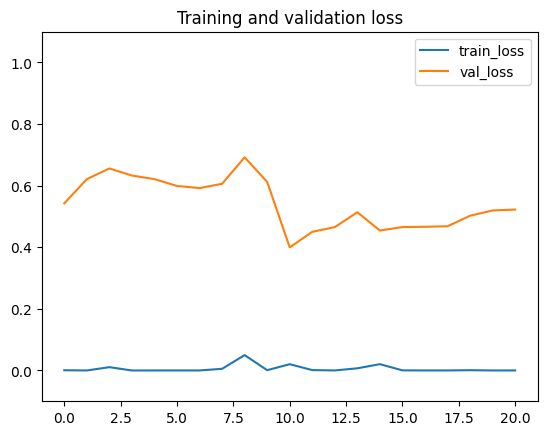

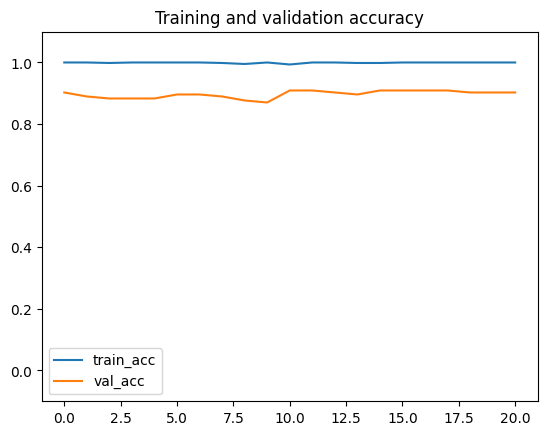

In [ ]:
## Accuracy plotlib

epochs = 21
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.ylim((-0.1,1.1))
plt.legend()

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.ylim((-0.1,1.1))
plt.legend()

In [ ]:
history_ = pd.DataFrame(history.history)
with open(os.path.join(path_, "vit_results_", "history.json"), "w") as json_file:
    history_.to_json(json_file)

In [ ]:
# Load model

model = load_model('MY_PATH_OF_MODEL_H5')

## **Testing model**

In [ ]:
# Inference with testgenerator

y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred_max = np.argmax(y_pred, 1)

print(y_pred[10])
print(y_pred_max[10])

6/6 [==============================] - 7s 891ms/step
(192, 10)
[1.9641649e-11 9.0022519e-07 2.1571894e-10 3.0554794e-08 1.6519262e-09
 3.9625252e-08 9.7174588e-09 2.7987654e-10 9.3954868e-06 9.9998957e-01]
9


In [ ]:
# Crop the test dataset to the lenght of the predictions, which is automatically a multiple of the batch size.

Y_test = y_test[:len(y_pred_max)]
print(sklearn.metrics.classification_report(Y_test, y_pred_max))

print("accuracy:", accuracy_score(Y_test, y_pred_max))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        17
           1       1.00      0.90      0.95        21
           2       1.00      0.94      0.97        18
           3       0.88      1.00      0.93        21
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        22
           6       0.95      1.00      0.98        20
           7       1.00      0.93      0.97        15
           8       1.00      0.80      0.89        20
           9       1.00      1.00      1.00        17

    accuracy                           0.95       192
   macro avg       0.96      0.95      0.95       192
weighted avg       0.96      0.95      0.95       192

accuracy: 0.953125


In [ ]:
test_data[2][0]

'/content/gdrive/MyDrive/DatasetNew/data/ic_CIE.rear.19774.jpg'

In [ ]:
## show results

for i in range(num_results):
    fig, ax = plt.subplots()
    ax.imshow(load_img(test_data[i][0]))
    ax.set_title(img_ids[y_pred_max[i]])
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Confusion Matrix

<Axes: >

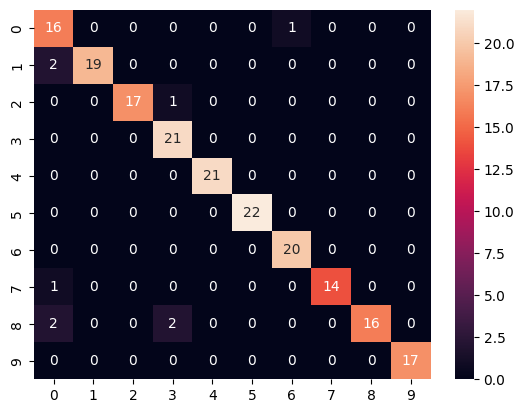

In [ ]:

conf = confusion_matrix(Y_test, y_pred_max)
sns.heatmap(conf, annot=True, fmt="d")

<Axes: >

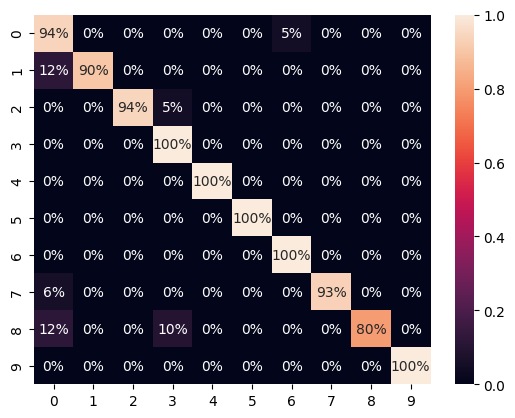

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True, fmt='.0%')